## XマッチのブキごとのXパワー分布

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 8)
date_to = dt.date(2023, 6, 14)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 7119


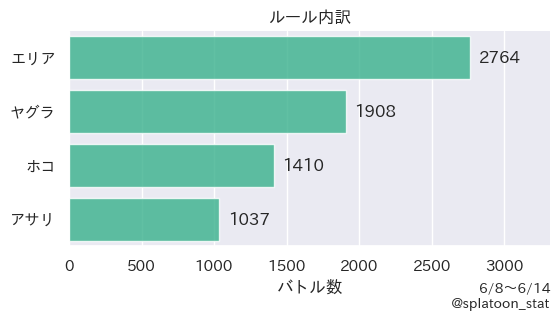

パワー不明バトル数: 831


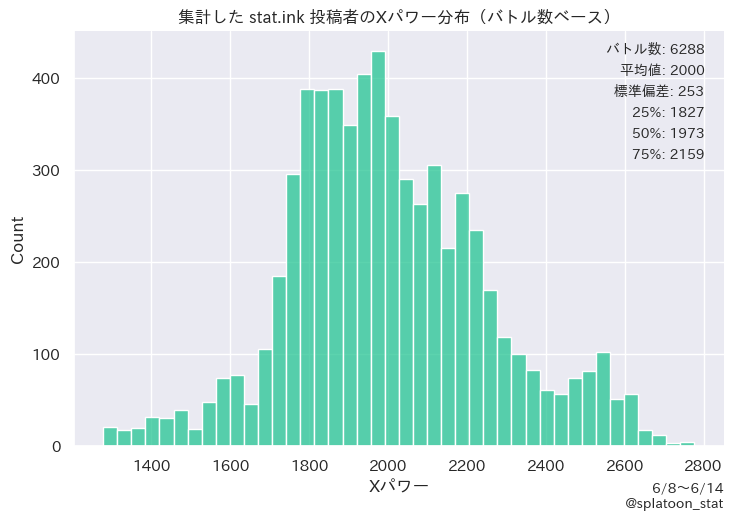

In [2]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [3]:
players = u.to_players(battles)

In [4]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame(name="usage")
usage_map = usage.reset_index().pivot(index="weapon", columns="mode", values="usage").reindex(d.MODE_ORDER, axis=1)
usage_map["mean"] = usage_map.mean(axis=1)
usage_map = usage_map.sort_values("mean", ascending=False)
usage_map

mode                  area    yagura      hoko     asari      mean
weapon                                                            
sshooter_collabo  0.052770  0.052486  0.058663  0.050282  0.053550
sshooter          0.031941  0.035939  0.053090  0.039813  0.040196
wakaba            0.041245  0.043950  0.027052  0.036093  0.037085
sharp             0.040469  0.026430  0.034448  0.042430  0.035944
sharp_neo         0.046671  0.039158  0.030902  0.026588  0.035830
...                    ...       ...       ...       ...       ...
carbon            0.000310  0.000374  0.001114  0.001515  0.000829
wideroller        0.000465  0.000898  0.000608  0.000964  0.000734
h3reelgun         0.000724  0.000374  0.000912  0.000413  0.000606
l3reelgun         0.000569  0.000449  0.000101  0.001102  0.000555
rapid_elite       0.000310  0.000599  0.000608  0.000551  0.000517

[90 rows x 5 columns]

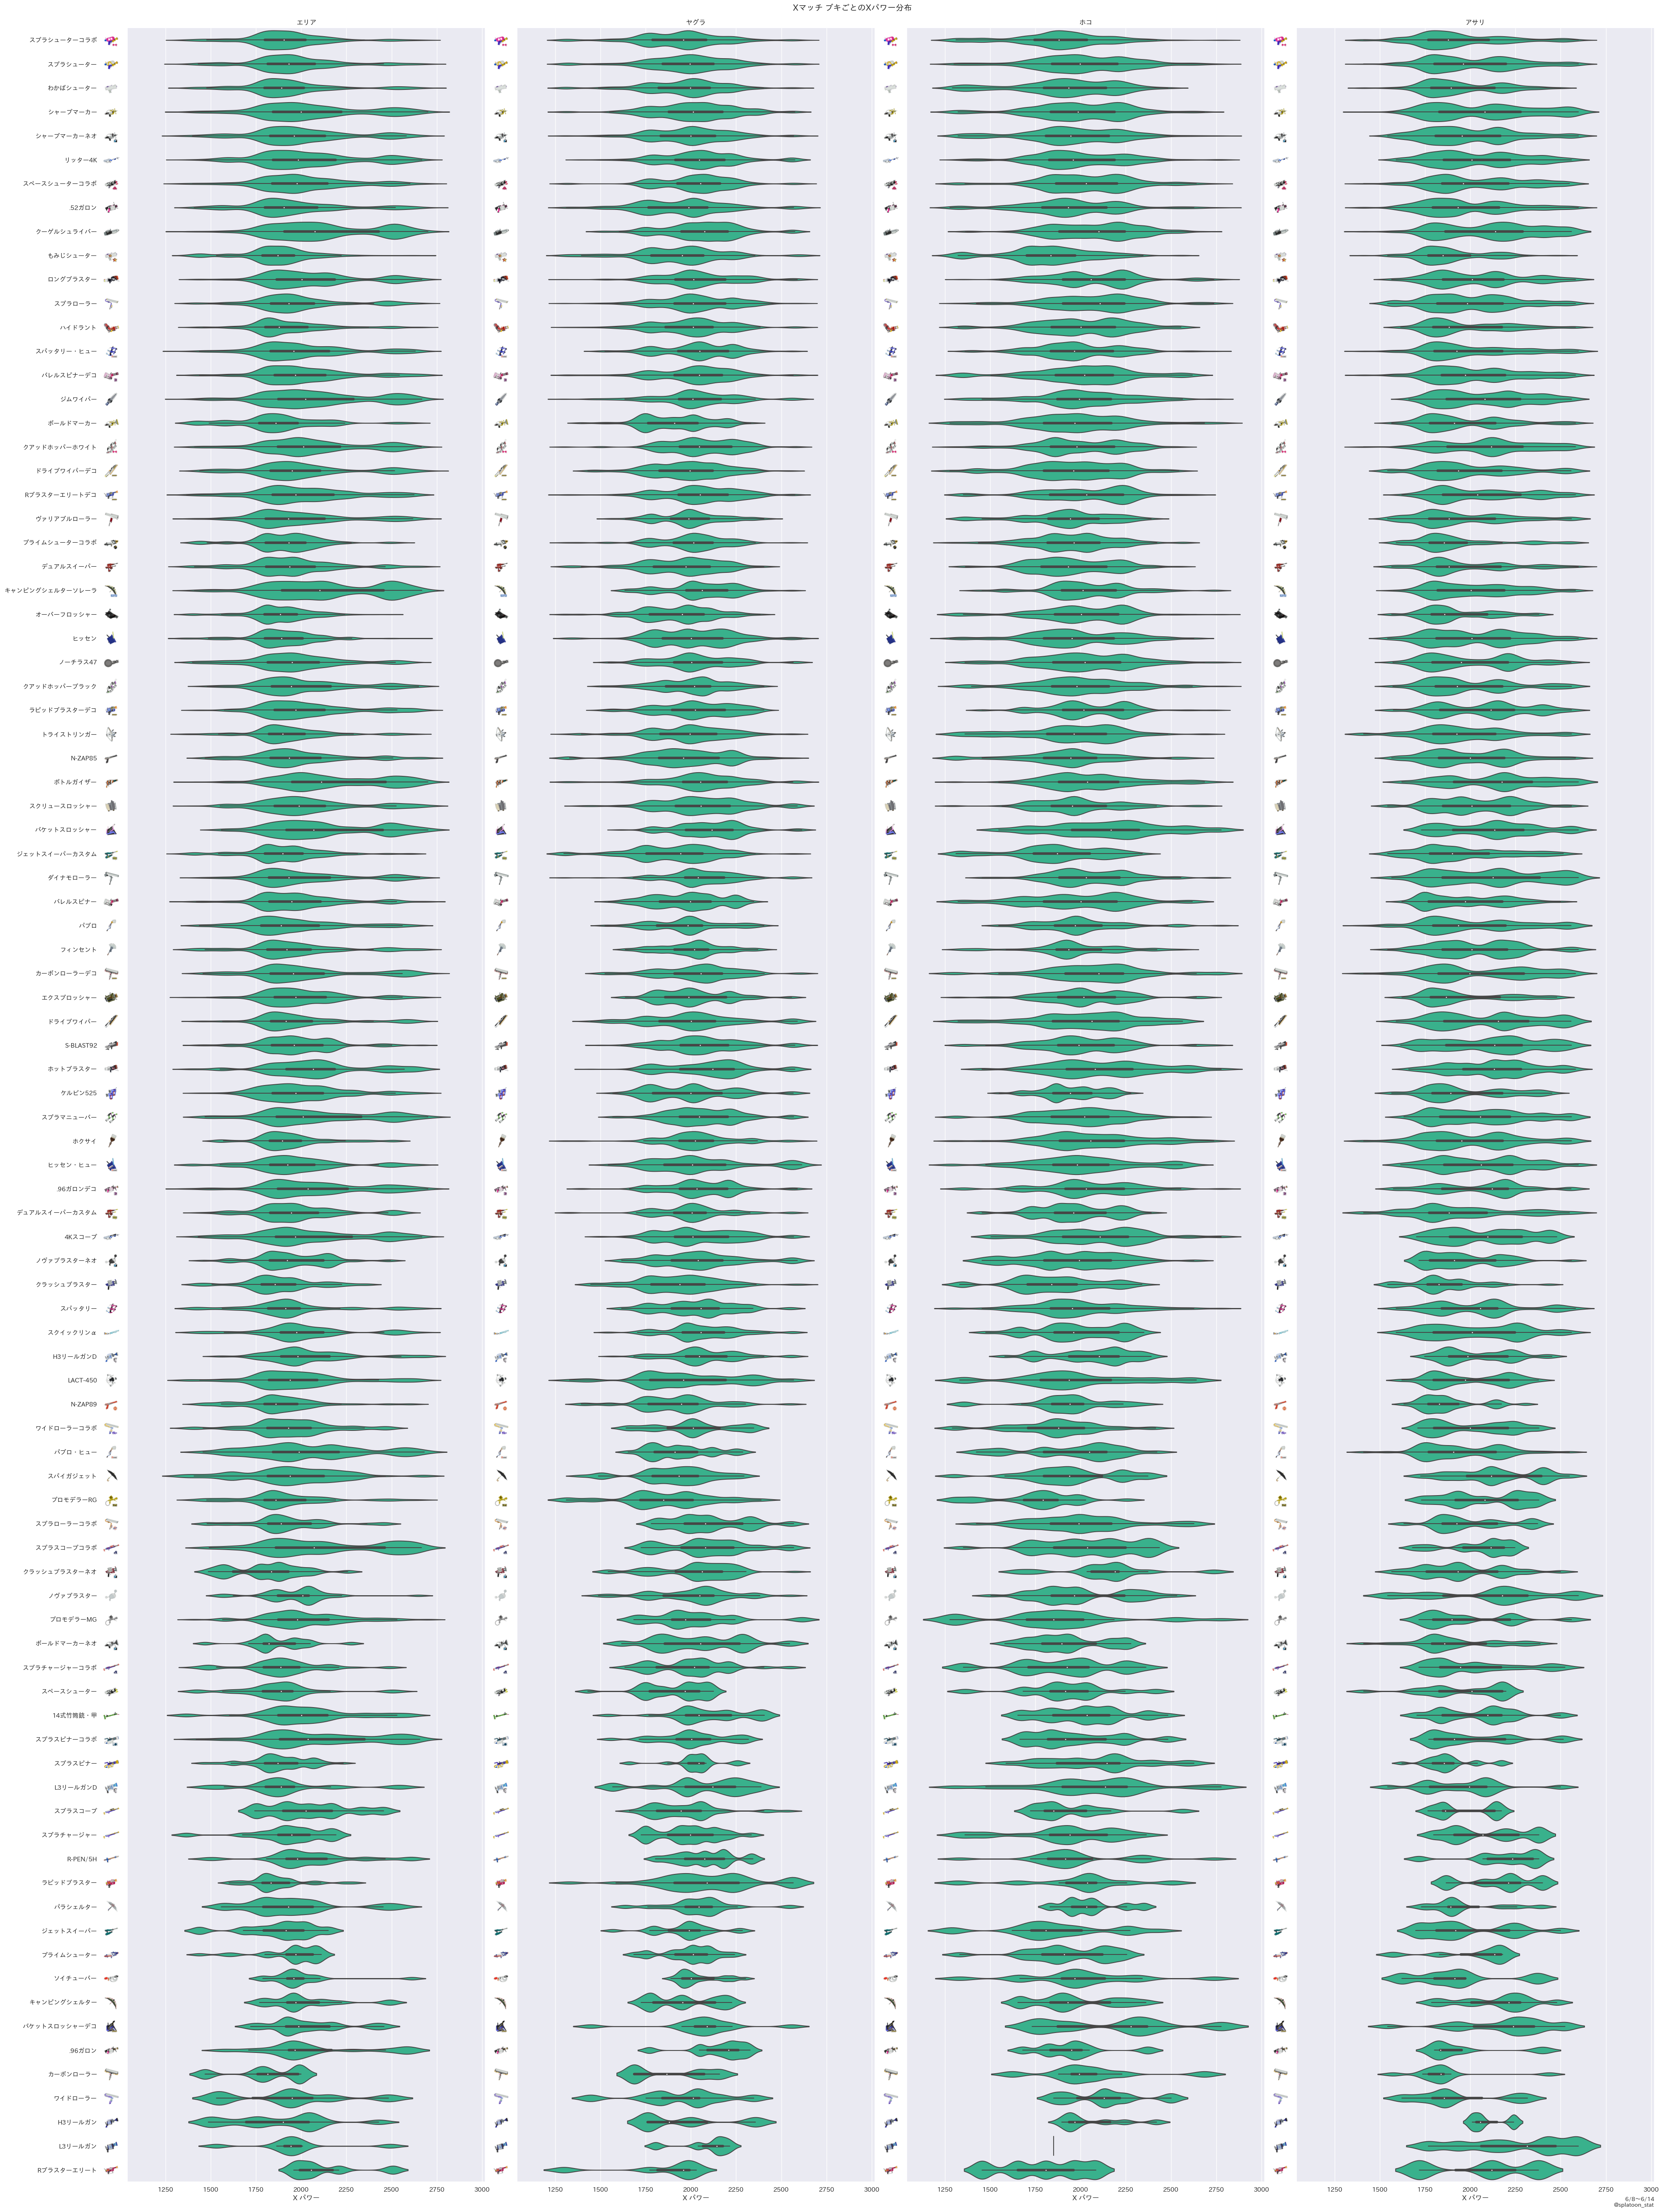

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("power", "X パワー", "X Power")
i18n.add("title", "${lobby} ブキごとのXパワー分布", "X Power distribution of each weapon in ${lobby} [%]")

width = 10
height = len(usage) * 0.15

g = sns.catplot(
    data=players,
    x="power",
    y="weapon",
    order=usage_map.index,
    col="mode",
    col_order=d.MODE_ORDER,
    kind="violin",
    scale="width",
    bw=.2,
    color=d.Color.XMATCH.value,
    height=height,
    aspect=width/height,
)

yticklabels = [i18n.t(x) for x in usage_map.index]

g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.fig.subplots_adjust(wspace=0.09)

g.set(
    xlabel=i18n.t("power"),
    ylabel="",
)
g.set_yticklabels(yticklabels, x=-0.07)

for i, ax in enumerate(g.axes[0]):
    mode_key = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode_key))

    xmin, xmax = ax.get_xlim()
    image_offset = xmin - (xmax - xmin) * 0.045
    for j, weapon in enumerate(usage_map.index):
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=.8)
        img.image.axes = ax
        ab = AnnotationBbox(img, (2000, 0), xybox=(image_offset, j), frameon=False, pad=0)
        ax.add_artist(ab)

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()